In [1]:

import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt


In [12]:
BATCH = 3
path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model'


annotator1 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'train',segment = 'mixed',annotator= 1)
train_GT1 = annotator1.train_loader

/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train
/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test_small


In [13]:
def display_multiclass_mask(mask, colors):
    """
    Funkcja do wyświetlania wieloklasowej maski jako obrazu RGB.
    
    :param mask: Maska z klasami jako różne warstwy.
    :param colors: Kolory odpowiadające każdej klasie.
    """
    # Usunięcie ewentualnego dodatkowego wymiaru
    if mask.shape[0] == 1:
        mask = mask.squeeze(0)
    
    # Inicjalizacja obrazu RGB
    rgb_image = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    
    # Iteracja przez każdą klasę i kolorowanie odpowiednich pikseli
    for class_id, color in enumerate(colors):
        # Ustawianie kolorów tam, gdzie maska klasy jest aktywna
        rgb_image[mask[:, :, class_id] == 1] = color
    
    # Wyświetlanie obrazu
    plt.imshow(rgb_image)
    plt.axis('off')  # Usunięcie osi dla lepszego wyświetlania
    plt.show()







In [15]:
from utils.augmentation import MyAugmentation
colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0],[0,0,255]]  # tło, wić, główka
# Utwórz obraz RGB z maski


for batch_idx, (inputs, intersections) in enumerate(train_GT1):
    #if batch_idx == 5:
        #break

    print(inputs.shape)
    augmentation = MyAugmentation()
    for j in range(inputs.shape[0]):
        inputs[j] = augmentation(inputs[j])    

    for i in range(1):
        mask_to_display = intersections[i].numpy().transpose(1, 2, 0)
        display_multiclass_mask(mask_to_display, colors)




torch.Size([3, 3, 512, 512])


AttributeError: 'tuple' object has no attribute 'shape'

In [16]:
import cv2

input = cv2.imread('/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train/GT1_full/0.png')
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

[ WARN:0@563.485] global loadsave.cpp:248 findDecoder imread_('/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train/GT1_full/0.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [20]:
import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random

def rgb_to_class_id(mask_rgb, class_colors):
        mask_id = np.zeros(mask_rgb.shape[:2], dtype=np.float32)
        for class_id, color in enumerate(class_colors):
            mask_id[(mask_rgb == color).all(axis=2)] = class_id
        return mask_id

class_colors = [[0, 0, 0], [0, 255, 0], [0, 0, 255]]  # tło, wić, główka
number = random.randint(0, 431)
print(f'Number = {number}')
number = 251

img = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/images/{number}.png')
x_img = img.astype(np.float32)
x_img = resize(x_img, (512, 512, 3), mode='constant', preserve_range=True)


        
# Load masks
mask = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT1_mixed/{number}.png')
mask = mask.astype(np.float32)
mask = resize(mask, (512, 512, 3), mode='constant', preserve_range=True)
mask_id = rgb_to_class_id(mask, class_colors)

hmask = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT1_head/{number}.png')
hmask = mask.astype(np.float32)
hmask = resize(hmask, (512, 512, 1), mode='constant', preserve_range=True)
#hmask_id = rgb_to_class_id(hmask, class_colors)
min_val = np.min(x_img)
max_val = np.max(x_img)
x_img = (x_img - min_val) / (max_val - min_val)


x_img = x_img.transpose(2, 0, 1)
x_img = torch.from_numpy(x_img)
mask_id = torch.from_numpy(mask_id)


augmentation = MyAugmentation()
x_img = augmentation(x_img)

mask_id1 = mask_id.squeeze(0).squeeze(0)
#mask_id = mask_id.permute(1,2,0)

print(mask_id.shape)

mask_to_display = mask_id1

colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka

# Utwórz obraz RGB z maski
mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    mask_rgb[mask_to_display == i] = color


plt.figure(figsize=(5, 5))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')


plt.figure(figsize=(50, 50))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(x_img.permute(1,2,0))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mask_rgb)
#plt.imshow(mask_id)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(mask)

plt.show()


plt.figure(figsize=(5, 5))
plt.imshow(x_img[0].permute(1,2,0))
plt.axis('off')




Number = 104


AttributeError: 'tuple' object has no attribute 'shape'

Number = 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

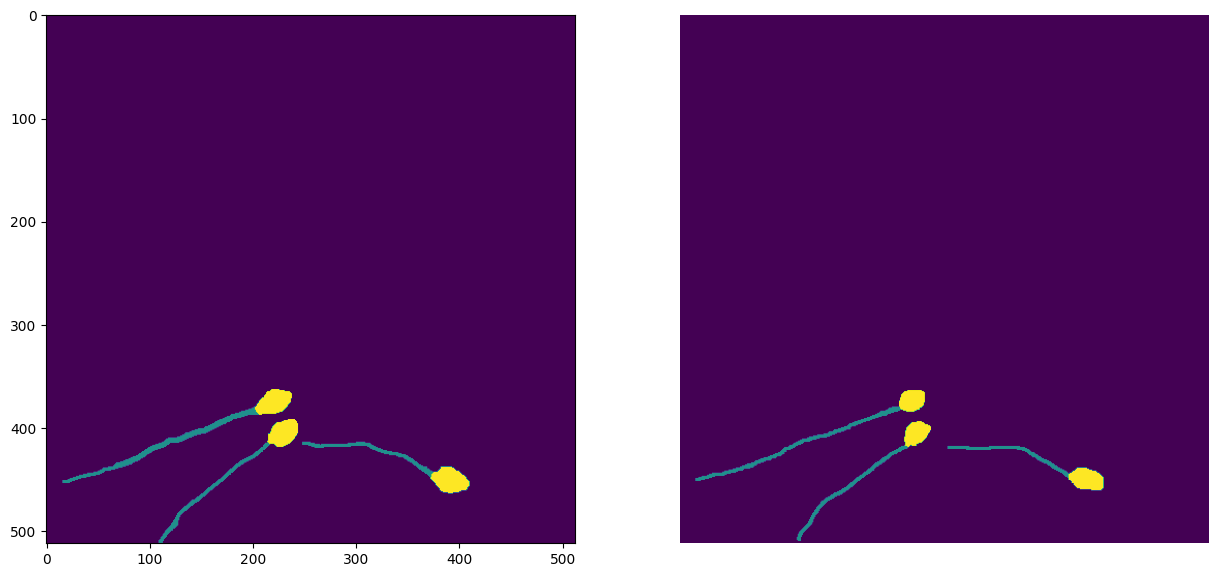

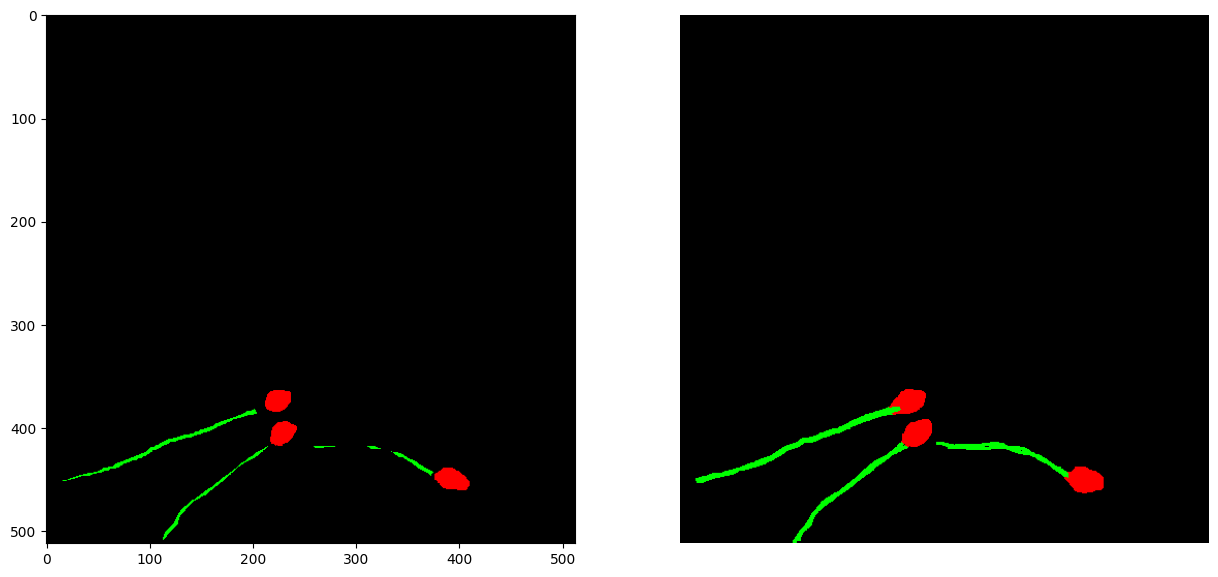

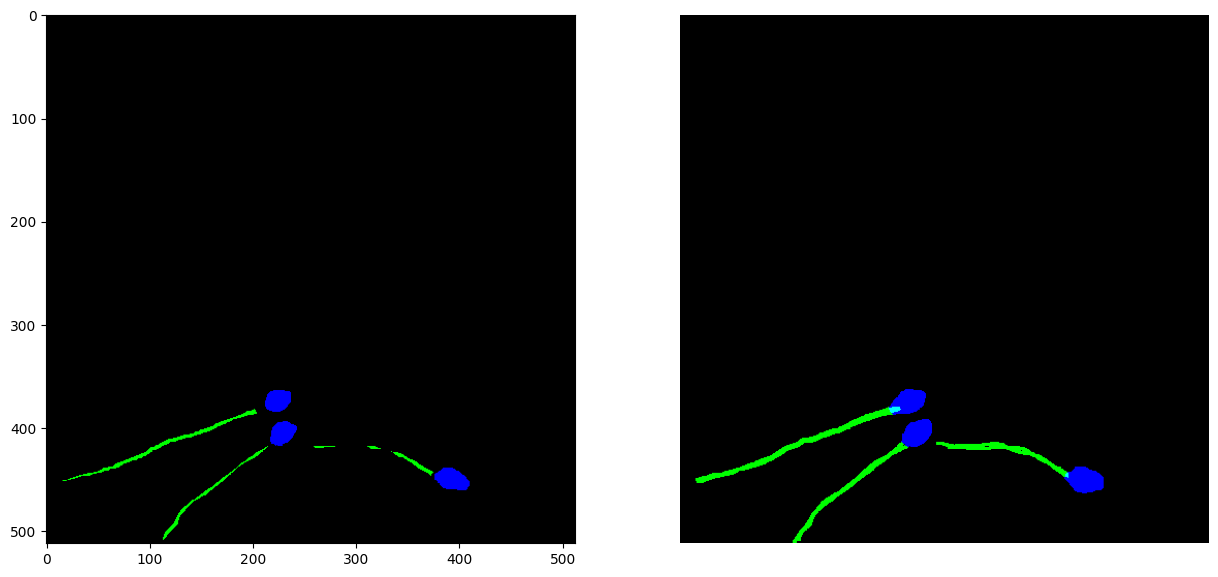

In [29]:
import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random

def rgb_to_class_id(mask_rgb, class_colors):
        mask_id = np.zeros(mask_rgb.shape[:2], dtype=np.float32)
        for class_id, color in enumerate(class_colors):
            idx = class_id
            if class_id == 3:
                idx = 1
            mask_id[(mask_rgb == color).all(axis=2)] = idx
        return mask_id

class_colors = [[0, 0, 0], [0, 255, 0], [0, 0, 255],[0,255,255]]  # tło, wić, główka
number = random.randint(0, 431)
print(f'Number = {number}')

img = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/images/{number}.png')
x_img = img.astype(np.float32)
x_img = resize(x_img, (512, 512, 3), mode='constant', preserve_range=True)

min_val = np.min(x_img)
max_val = np.max(x_img)
x_img = (x_img - min_val) / (max_val - min_val)
        
# Load masks
#GT1_mixed
mask1 = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT1_mixed/{number}.png')
mask1 = mask1.astype(np.float32)
mask1 = resize(mask1, (512, 512, 3), mode='constant', preserve_range=True)
mask_id_1 = rgb_to_class_id(mask1, class_colors)
#GT2_mixed
mask2 = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT2_mixed/{number}.png')
mask2 = mask2.astype(np.float32)
mask2 = resize(mask2, (512, 512, 3), mode='constant', preserve_range=True)
mask_id_2 = rgb_to_class_id(mask2, class_colors)

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(mask_id_1)
plt.subplot(1,2,2)
plt.imshow(mask_id_2)
plt.axis('off')


intersection = cv2.bitwise_and(mask1, mask2)
union = cv2.bitwise_or(mask1, mask2)

intersection_id = rgb_to_class_id(intersection, class_colors)
union_id = rgb_to_class_id(union, class_colors)


colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka
# Utwórz obraz RGB z maski
mask_to_display = intersection_id
intersection_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    intersection_rgb[mask_to_display == i] = color

mask_to_display = union_id
union_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    union_rgb[mask_to_display == i] = color
    

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(intersection_rgb)
plt.subplot(1,2,2)
plt.imshow(union_rgb)
plt.axis('off')


plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(intersection)
plt.subplot(1,2,2)
plt.imshow(union)
plt.axis('off')




In [19]:
import torch
import torch.nn as nn

# Załóżmy, że weights to tensor o długości równej liczbie klas, tutaj 4.
# Dla przykładu, wszystkie wagi ustawione są na 1. Możesz je dostosować w zależności od potrzeb.
weights = torch.ones([4,512,512])
weights[0] = 0.1 
weights[1] = 0.7
weights[2] = 0.4
weights[3] = 0.4

# Utwórz funkcję straty z pos_weight
loss_fn = nn.BCEWithLogitsLoss(weight=weights)

# Zakładając, że output i ids mają wymiary [22, 4, 512, 512], jak wspomniano
output = torch.randn(22, 4, 512, 512)  # Przykładowy tensor wyjściowy modelu
ids = torch.empty(22, 4, 512, 512).random_(2).float()  # Przykładowy tensor docelowy

# Oblicz stratę
loss = loss_fn(output, ids)
print(loss)

tensor(0.3224)


In [17]:
target = torch.ones([10, 64,512,512], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64,512,512], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(weight=pos_weight)
criterion(output, target)  # -log(sigmoid(1.5))

RuntimeError: The size of tensor a (512) must match the size of tensor b (64) at non-singleton dimension 3